In [1]:
import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt
import matplotlib as mpl
import sionna.rt as rt
import numpy as np

In [2]:
# from Anshul's notebook
mat_lunar_highland = rt.RadioMaterial(
    name="lunar-highland",
    thickness=11,
    relative_permittivity=2.7,
    conductivity=10**(-12.5),
    scattering_coefficient=0.4,
    xpd_coefficient=0.1,
    scattering_pattern='lambertian',
    frequency_update_callback=None,
    color=None,
    props=None)

mat_lunar_mare = rt.RadioMaterial(
    name="lunar-mare",
    thickness=5,
    relative_permittivity=2.7,
    conductivity=10**(-12.5),
    scattering_coefficient=0.4,
    xpd_coefficient=0.1,
    scattering_pattern='lambertian',
    frequency_update_callback=None,
    color=None,
    props=None)

In [3]:
from sionna.rt import Scene, RadioMaterial, HolderMaterial, PlanarArray, Transmitter

N = 100
vert_x, vert_y = np.meshgrid(
    np.linspace(0, 10, N),
    np.linspace(0, 10, N),
    indexing="xy")
vert_z = (np.sin(2 * vert_x) + np.sin(2 * vert_y)) / 2
vert_xyz = np.stack([vert_x, vert_y, vert_z], axis=2).reshape(-1, 3)

# Triangulate
vertex_indices = np.arange(N * N)
is_last_column = (vertex_indices + 1) % N == 0
is_last_row = vertex_indices // N == N - 1
ii = vertex_indices[~is_last_row & ~is_last_column]
faces = np.stack([[ii, ii + 1, ii + N + 1], [ii, ii + N + 1, ii + N]])
faces = np.concatenate(faces.T, axis=-1).T

# Create scene
props = mi.Properties()
props["material"] = mat_lunar_highland
# props["material"] = rt.ITURadioMaterial("mat", itu_type="concrete", thickness=10)
# props["material"] = RadioMaterial("mat", thickness=10, relative_permittivity=100)
# Sionna requires bsdfs to be wrapped in HolderMaterial
props["material"] = HolderMaterial(props)
mi_mesh = mi.Mesh(name="terrain",
                    vertex_count=vert_xyz.shape[0],
                    face_count=faces.shape[0], 
                    props=props)
mi_mesh_params = mi.traverse(mi_mesh)
mi_mesh_params["vertex_positions"] = mi.Float(vert_xyz.ravel().astype(np.float32))
mi_mesh_params["faces"] = mi.UInt(faces.ravel().astype(np.uint32))
mi_mesh_params.update()
mi_scene = mi.load_dict({
    "type": "scene",
    "terrain": mi_mesh
})
scene = Scene(mi_scene)
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")
tx = Transmitter(name="tx",
                 position=mi.Point3f(0, 0, 1),
                 orientation=mi.Point3f(0,0,0),
                 power_dbm=100)
scene.add(tx)

In [4]:
meas_surf = mi.Mesh(name="terrain",
                    vertex_count=vert_xyz.shape[0],
                    face_count=faces.shape[0], 
                    props=props)
meas_surf_params = mi.traverse(meas_surf)
# vert_xyz_ms = vert_xyz * np.array([1, 1, 0])
vert_xyz_ms = vert_xyz + np.array([0, 0, 0.01])
meas_surf_params["vertex_positions"] = mi.Float(vert_xyz_ms.ravel().astype(np.float32))
meas_surf_params["faces"] = mi.UInt(faces.ravel().astype(np.uint32))
meas_surf_params.update();

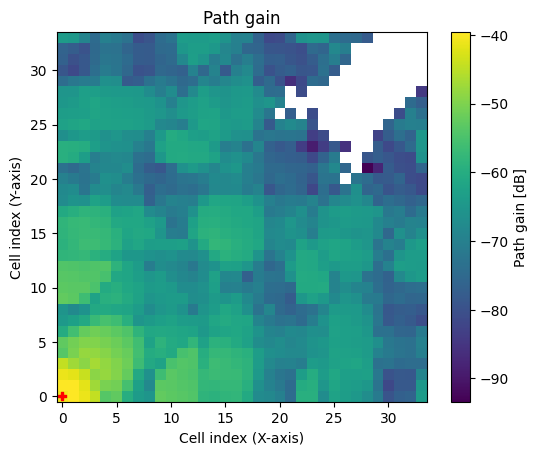

In [5]:
rm_solver = rt.RadioMapSolver()
rm = rm_solver(scene=scene, 
               meas_surf=meas_surf, 
               cell_size=[0.3, 0.3],
               samples_per_tx=int(1e7),
               diffuse_reflection=False,
               max_depth=5)
rm.show();

In [24]:
from tqdm import tqdm

front_cam = rt.Camera(position=[-10, 0, 8], look_at=[3, 5, 0])
back_cam = rt.Camera(position=[2, 20, 9], look_at=[5, 5, 0])
data = {"front": [], "back": [], "rm": []}
spp = 64
max_depths = [1, 3, 5, 7]
for max_depth in tqdm(max_depths):
    rm = rm_solver(scene=scene, 
                   meas_surf=meas_surf, 
                   cell_size=[0.3, 0.3],
                   samples_per_tx=int(1e5),
                   diffuse_reflection=True,
                   max_depth=max_depth)
    data["rm"].append(rm)
    img = scene.render(camera=front_cam, radio_map=rm, return_bitmap=True, num_samples=spp, show_devices=False)
    data["front"].append(img.convert(mi.Bitmap.PixelFormat.RGBA, mi.Struct.Type.UInt8, True))
    img = scene.render(camera=back_cam, radio_map=rm, return_bitmap=True, num_samples=spp, show_devices=False)
    data["back"].append(img.convert(mi.Bitmap.PixelFormat.RGBA, mi.Struct.Type.UInt8, True))

100%|██████████| 4/4 [00:13<00:00,  3.32s/it]


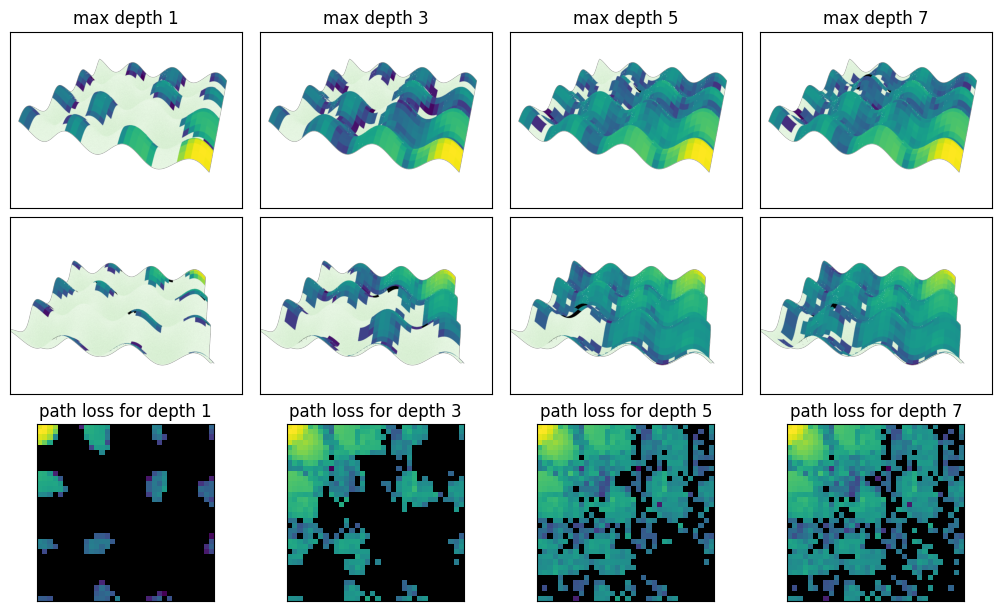

In [25]:
fig, axs = plt.subplots(3, 4, constrained_layout=True)
fig.set_size_inches(10, 6)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
norm = mpl.colors.Normalize(
    np.min([10 * np.log10(np.maximum(1e-6, rm.path_gain)) for rm in data["rm"]]),
    np.max([10 * np.log10(np.maximum(1e-6, rm.path_gain)) for rm in data["rm"]]))
for j in range(4):
    for i, key in enumerate(["front", "back"]):
        axs[i, j].imshow(data[key][j])
    path_gain = np.squeeze(data["rm"][j].path_gain)
    tex, _ = rt.utils.radio_map_texture(path_gain)
    # linear -> sRGB
    axs[2, j].imshow(np.power(tex, 1/2.2))

for k in range(4):
    axs[0, k].set_title(f"max depth {max_depths[k]}")
    axs[2, k].set_title(f"path loss for depth {max_depths[k]}")

In [26]:
# only run this once!
cell_centers = data["rm"][0].cell_centers.numpy()
cell_centers = np.reshape(cell_centers, [-1,3])
for i, pos in enumerate(cell_centers):
    scene.add(rt.Receiver(name=f"rx-{i}",
                        position=mi.Point3f(pos),
                        orientation=mi.Point3f(0., 0., 0.)))
scene.rx_array =  PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="iso",
                              polarization="VH")

In [27]:
def paths_to_coverage_map(paths):
    """
    Converts paths into the equivalent coverage map values.
    The coverage map is assumed to be a square.
    """
    # [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
    a_real, a_imag = paths.a
    a = a_real.numpy() + 1j*a_imag.numpy()

    # Transmit precoding
    # Assume default precoding
    # [num_rx, num_rx_ant, num_tx, num_paths]
    a /= np.sqrt(a.shape[3])
    a = np.sum(a, axis=3)

    # Sum energy of paths
    a = np.square(np.abs(a))
    # [num_rx, num_tx]
    a = np.sum(a, axis=(1, 3))

    # Swap dims
    # [num_tx, num_rx]
    a = a.T

    # Reshape to coverage map
    n = int(np.sqrt(a.shape[1]))
    shape = [a.shape[0], n, n]
    a = np.reshape(a, shape)

    return a

In [28]:
def paths_to_radio_map(paths):
    rm_raw = paths_to_coverage_map(paths)
    rm = rt.RadioMap(scene=scene, 
                     meas_surf=meas_surf, 
                     cell_size=[0.3, 0.3])
    # fake a RadioMap object by updating the backing array with values from the multi-receiver method
    dr.scatter(rm._pathgain_map.array, np.ravel(rm_raw), np.arange(np.prod(rm_raw.shape)))
    return rm

In [32]:
from time import perf_counter

max_depths = np.arange(6)
res: dict[str, list[rt.RadioMap]] = {"shoot_and_bounce": [], "antenna_pairs": []}
rm_solver = rt.RadioMapSolver()

# for some reason drjit implodes if I try to wrap this in a python for loop
def block(max_depth):
    path_solver = rt.PathSolver()
    paths = path_solver(
        scene=scene,
        max_depth=max_depth,
        max_num_paths_per_src=int(4e6),
        samples_per_src=int(4e6),
        synthetic_array=True,
        los=True,
        specular_reflection=True,
        diffuse_reflection=True,
        refraction=True,
    )
    res["antenna_pairs"].append(paths_to_radio_map(paths))

max_depth = 0
while max_depth <= 5:
    print(f"Running with depth = {max_depth}")
    start = perf_counter()
    block(max_depth)
    stop = perf_counter()
    print(f"Finished antenna pairs method. Took {stop - start} seconds.")

    start = perf_counter()
    rm = rm_solver(
        scene=scene, 
        meas_surf=meas_surf, 
        cell_size=[0.3, 0.3],
        proj_normal=[0, 0, 1],
        samples_per_tx=int(1e6),
        max_depth=max_depth,
        los=True,
        diffuse_reflection=True,
        refraction=True,
    )
    res["shoot_and_bounce"].append(rm)
    stop = perf_counter()
    print(f"Finished shoot and bounce method. Took {stop - start} seconds.")

    max_depth += 1

Running with depth = 0
Finished antenna pairs method. Took 0.36884429201018065 seconds.
Finished shoot and bounce method. Took 0.08788124995771796 seconds.
Running with depth = 1
Finished antenna pairs method. Took 21.936004457995296 seconds.
Finished shoot and bounce method. Took 0.07876591599779204 seconds.
Running with depth = 2
Finished antenna pairs method. Took 30.396230500016827 seconds.
Finished shoot and bounce method. Took 0.07919908402254805 seconds.
Running with depth = 3
Finished antenna pairs method. Took 35.57537400000729 seconds.
Finished shoot and bounce method. Took 0.08159204199910164 seconds.
Running with depth = 4
Finished antenna pairs method. Took 38.23352037498262 seconds.
Finished shoot and bounce method. Took 0.08749212505063042 seconds.
Running with depth = 5
Finished antenna pairs method. Took 39.70041766698705 seconds.
Finished shoot and bounce method. Took 0.08331683301366866 seconds.


/var/folders/dp/9xqdy2vn535883dxlm82nwtc0000gn/T/ipykernel_52514/3861375869.py:2: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(np.squeeze(path_gain))


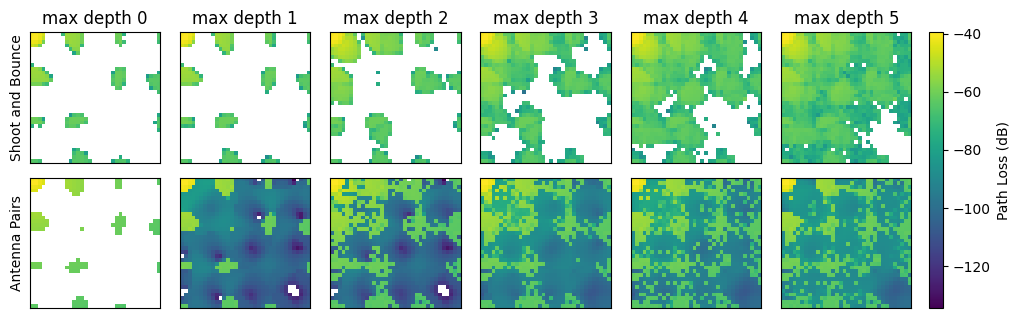

In [68]:
def path_gain_to_db(path_gain):
    return 10 * np.log10(np.squeeze(path_gain))

def filter_valid(arr):
    return np.array(arr)[np.isfinite(np.array(arr))]

fig, axs = plt.subplots(ncols=len(max_depths), nrows=2, constrained_layout=True)
fig.get_layout_engine().set(w_pad=0.01, h_pad=0.01, hspace=0.1, wspace=0.1)
fig.set_size_inches(10, 3)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])
rms_raw = np.array([rm.path_gain for rm in res["shoot_and_bounce"]])
rms = path_gain_to_db(rms_raw)
rms_ref_raw = np.array([rm.path_gain for rm in res["antenna_pairs"]])
rms_ref = path_gain_to_db(rms_ref_raw)
norm = mpl.colors.Normalize(
    np.min(filter_valid([rms, rms_ref])), 
    np.max(filter_valid([rms, rms_ref])))
for i, max_depth in enumerate(max_depths):
    axs[0, i].imshow(rms[i], norm=norm)
    axs[1, i].imshow(rms_ref[i], norm=norm)
    axs[0, i].set_title(f"max depth {max_depth}")
axs[0, 0].set_ylabel("Shoot and Bounce")
axs[1, 0].set_ylabel("Antenna Pairs")
plt.colorbar(mpl.cm.ScalarMappable(norm), ax=axs, pad=0.02, label="Path Loss (dB)")

In [69]:
renders = []
spp = 64
for i, max_depth in enumerate(max_depths):
    img = scene.render(camera=front_cam, radio_map=rm, return_bitmap=True, num_samples=spp, show_devices=False)
    rm = res["shoot_and_bounce"][i]
    renders.append(img.convert(mi.Bitmap.PixelFormat.RGBA, mi.Struct.Type.UInt8, True))
for i, max_depth in enumerate(max_depths):
    rm = res["shoot_and_bounce"][i]
    img = scene.render(camera=back_cam, radio_map=rm, return_bitmap=True, num_samples=spp, show_devices=False)
    renders.append(img.convert(mi.Bitmap.PixelFormat.RGBA, mi.Struct.Type.UInt8, True))
for i, max_depth in enumerate(max_depths):
    img = scene.render(camera=front_cam, radio_map=rm, return_bitmap=True, num_samples=spp, show_devices=False)
    rm = res["antenna_pairs"][i]
    renders.append(img.convert(mi.Bitmap.PixelFormat.RGBA, mi.Struct.Type.UInt8, True))
for i, max_depth in enumerate(max_depths):
    rm = res["antenna_pairs"][i]
    img = scene.render(camera=back_cam, radio_map=rm, return_bitmap=True, num_samples=spp, show_devices=False)
    renders.append(img.convert(mi.Bitmap.PixelFormat.RGBA, mi.Struct.Type.UInt8, True))

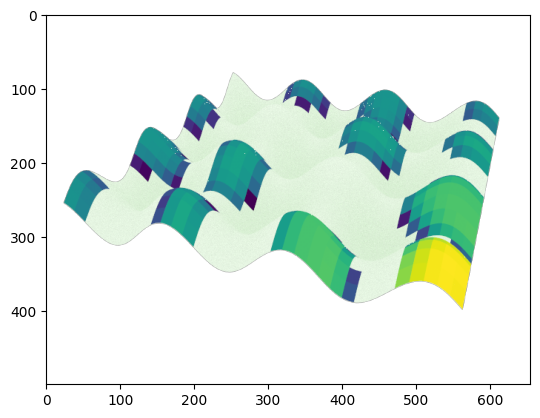

In [ ]:
plt.imshow(renders[2])

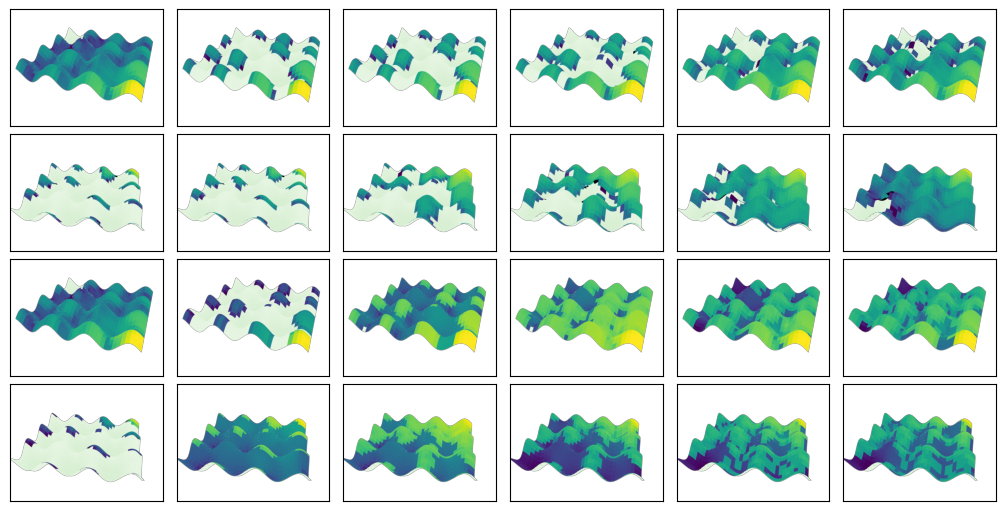

In [76]:
fig, axs = plt.subplots(nrows=4, ncols=len(max_depths), constrained_layout=True)
fig.set_size_inches(10, 5)
for i, ax in enumerate(axs.flat):
    ax.set(xticks=[], yticks=[])
    ax.imshow(renders[i])

/var/folders/dp/9xqdy2vn535883dxlm82nwtc0000gn/T/ipykernel_52514/620988717.py:3: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(np.squeeze(path_gain))
/var/folders/dp/9xqdy2vn535883dxlm82nwtc0000gn/T/ipykernel_52514/620988717.py:30: RuntimeWarning: invalid value encountered in subtract
  mappable = axs[2, i].imshow(np.abs(rms[i] - rms_ref[i]))


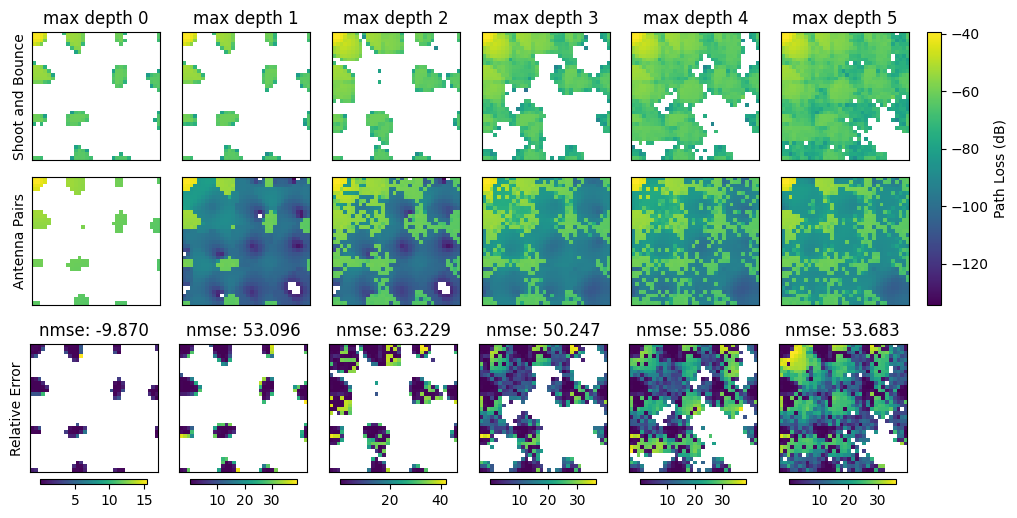

In [64]:
def path_gain_to_db(path_gain):
    # path_gain = np.maximum(np.squeeze(np.array(path_gain)), 1e-8)
    return 10 * np.log10(np.squeeze(path_gain))

def filter_valid(arr):
    return np.array(arr)[np.isfinite(np.array(arr))]

fig, axs = plt.subplots(ncols=len(max_depths), nrows=3, constrained_layout=True)
fig.get_layout_engine().set(w_pad=0.01, h_pad=0.01, hspace=0.1, wspace=0.1)
fig.set_size_inches(10, 5)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])
rms_raw = np.array([rm.path_gain for rm in res["shoot_and_bounce"]])
rms = path_gain_to_db(rms_raw)
rms_ref_raw = np.array([rm.path_gain for rm in res["antenna_pairs"]])
rms_ref = path_gain_to_db(rms_ref_raw)
norm = mpl.colors.Normalize(
    np.min(filter_valid([rms, rms_ref])), 
    np.max(filter_valid([rms, rms_ref])))
# diff = np.squeeze(10 * np.log10(np.abs(rms_raw - rms_ref_raw)))
# diff = np.squeeze(np.abs((10 * np.log10(rms_raw)) - (10 * np.log10(rms_ref_raw))))
# diff_valid = diff[np.isfinite(diff)]
# norm_diff = mpl.colors.Normalize(np.min(diff_valid), np.max(diff_valid))
for i, max_depth in enumerate(max_depths):
    axs[0, i].imshow(rms[i], norm=norm)
    axs[1, i].imshow(rms_ref[i], norm=norm)
    axs[0, i].set_title(f"max depth {max_depth}")
    with np.errstate(divide="ignore", invalid="ignore"):
        err = np.abs(rms_raw[i] - rms_ref_raw[i]) / np.abs(rms_ref_raw[i])
    mappable = axs[2, i].imshow(np.abs(rms[i] - rms_ref[i]))
    nmse_db = 10*np.log10(np.mean(err[np.isfinite(err)]**2))
    axs[2, i].set_title(f"nmse: {nmse_db:.3f}")
    plt.colorbar(mappable, ax=axs[2, i], location="bottom", shrink=0.8)
axs[0, 0].set_ylabel("Shoot and Bounce")
axs[1, 0].set_ylabel("Antenna Pairs")
axs[2, 0].set_ylabel("Relative Error")
plt.colorbar(mpl.cm.ScalarMappable(norm), ax=axs[0:2, :], pad=0.02, label="Path Loss (dB)")
# plt.colorbar(mpl.cm.ScalarMappable(norm_diff), ax=axs[2, :], pad=0.02, label="Absolute dB Diff.")

In [31]:
# Test error the way that the actual tests do
errs = []
for i, (rm, rm_ref) in enumerate(zip(rms_raw, rms_ref_raw)):
    with np.errstate(divide="ignore", invalid="ignore"):
        err = np.abs(rm - rm_ref) / np.abs(rm_ref)
    nmse_db = 10*np.log10(np.mean(err[np.isfinite(err)]**2))
    errs.append(nmse_db)
errs

[np.float32(-9.870046),
 np.float32(84.58416),
 np.float32(107.23811),
 np.float32(71.27831),
 np.float32(89.30298),
 np.float32(67.10532)]

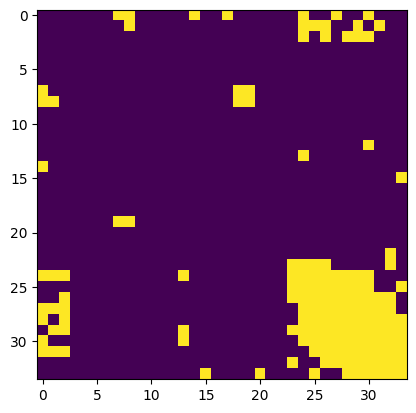

In [51]:
plt.imshow(np.squeeze(np.abs(rms_ref_raw[i])) < 1e-9)

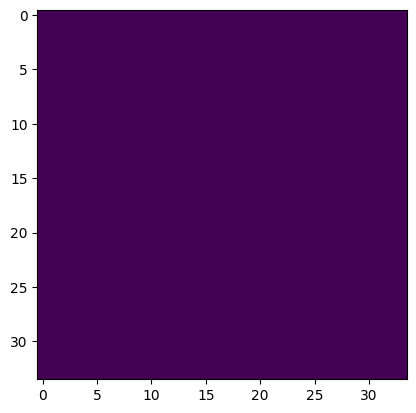

In [42]:
err = np.squeeze(np.abs(rms_raw[i] - rms_ref_raw[i]) / np.abs(rms_ref_raw[i]))
plt.imshow(np.isfinite(err))

In [41]:
np.abs(rms_raw[i] - rms_ref_raw[i]) / np.abs(rms_ref_raw[i])

array([[[4.4768717e-02, 5.1317066e-02, 1.3847227e-01, ...,
         9.1889566e-01, 9.2111462e-01, 2.7309352e-01],
        [4.1246481e-02, 2.3577580e-02, 3.3030208e-02, ...,
         4.3226028e+01, 9.3208861e-01, 2.8856051e-01],
        [1.4322096e-01, 2.3556650e-02, 1.1848865e-01, ...,
         2.1317589e+01, 9.7676611e-01, 6.7381029e+00],
        ...,
        [4.7626400e+01, 8.3896652e+01, 4.1140007e+01, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [9.0739948e-01, 9.1929960e-01, 9.9551034e-01, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0913676e-01, 2.4893323e-01, 5.3884888e-01, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00]]],
      shape=(1, 34, 34), dtype=float32)